# Lab 4

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

Welcome to the fourth lab. In this lab, we will derive the backpropagation equations, 
code the training procedure, and test it on our beloved dataset with five points.

## Imports

In [1]:
from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import Tensor

set_matplotlib_formats('png', 'pdf')


## Exercise 1
Consider a neural network with $L$ layers and a loss function
$\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})$. Call the output of the $i$-th
unit of the $\ell$-th layer $\textbf{z}^{(\ell)}_{i,out}=\sigma^{(\ell)}(\textbf{z}^{(\ell)}_{i,in})$
with $\textbf{z}^{(\ell)}_{i,in}=\sum_j\textbf{W}^{(\ell)}_{ji}\textbf{z}^{(\ell-1)}_{j,out}+\textbf{b}^{(\ell)}_{i}$
its pre-activation output. Finally, consider $\delta^{(\ell)}_i=\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})/\partial\mathbf{z}^{(\ell)}_{i,in}$
the gradient of the loss with respect to the pre-activation outputs of layer $\ell$.

Derive the back-propagation algorithm for a network with arbitrary architecture.
You might find the results of the previous lab a useful reference, as well as chapter
5 of the book _Mathematics for Machine Learning_ (https://mml-book.github.io).


1. Show that

\begin{align}
\delta^{(L)}_i &= \frac{\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial\textbf{z}^{(L)}_{i,out}}
\cdot{\sigma^\prime}^{(L)}(\textbf{z}^{(L)}_{i,in})
\\
\frac{\partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial \textbf{W}^{(\ell)}_{ji}}&=\delta^{(\ell)}_i\cdot\textbf{z}^{(\ell-1)}_{j,out} \\
\frac{\partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial \textbf{b}^{(\ell)}_{i}}&=\delta^{(\ell)}_i \\
\delta^{(\ell-1)}_i&=\left(\sum_k\delta^{(\ell)}_k\cdot\textbf{W}^{(\ell)}_{ik}\right)\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{i,in})
\end{align}

2. Use vectorized operations (i.e., operations with vectors and matrices) to compute
the gradients with respect to a single sample.

3. (Optional) Extend the vectorized operations to handle data in batches, and show that:

\begin{align}
\Delta^{(L)}&=\nabla_{\textbf{Z}^{(L)}_{out}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})\odot{\sigma^\prime}^{(L)}(\textbf{Z}^{(L)}_{in}) \\
\nabla_{\textbf{W}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(\ell)}_{out})&={\textbf{Z}^{(\ell-1)}_{out}}^T \cdot\Delta^{(\ell)} \\
\nabla_{\textbf{b}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})&=\sum_i {\Delta^{(\ell)}_i}^T \\
\Delta^{(\ell-1)}&=\Delta^{(\ell)}{\textbf{W}^{(\ell)}}^T\odot{\sigma^\prime}^{(\ell-1)}(\textbf{Z}^{(\ell-1)}_{in})
\end{align}

where $\Delta^{(\ell)}$, $\textbf{Y}$ and $\textbf{Z}^{(\ell)}_{out}$ are matrices whose $i$-th row contain the respective vectors $\delta$, $\textbf{y}$ and $\textbf{z}^{(\ell)}_{\cdot,out}$ for the $i$-th sample in the batch, and $\odot$ is the element-wise product.



## Exercise 2
In this exercise, we will code the backpropagation algorithm
and apply it to our five-points dataset.

First, let's define some structures to quickly create a neural network with layers of
given size. It will use tanh activation in the hidden layers and sigmoid for
the output layer. Although we will use it for classification, we use the mean squared
error loss for a change.

**NOTE**: We use PyTorch only as computation engine. To showcase how backpropagation
works under the hood, we do not utilize auto diff or other structures like modules or
autograd functions in this example (just basic OOP). However, we still use some
conventions like forward/backward notation.

In [3]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = self._init_glorot(in_features, out_features)
        self.bias = torch.zeros(out_features)

        self.weight_grad: Optional[Tensor] = None
        self.bias_grad: Optional[Tensor] = None

    # weight matrix: in_features =: N_i many rows, out_features =: N_o many columns, N_i x N_o
    @staticmethod
    def _init_glorot(in_features: int, out_features: int) -> Tensor:
        """Init a weight matrix with glorot initialization."""
        b = torch.sqrt(torch.tensor([6. / (in_features + out_features)]))
        return (2 * b) * torch.rand(in_features, out_features) - b

    # x: result of last layer, row vector: 1 x N_i
    # self.bias: 1 x N_o
    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weight + self.bias

class Sigmoid:
    def __init__(self):
        self.func = lambda x: 1 / (1 + torch.exp(-x))

    # x: 1 x N_i
    # result of function call: 1 x N_i
    def forward(self, x: Tensor) -> Tensor:
        return self.func(x)

    # same as above
    def get_gradient(self, x: Tensor) -> Tensor:
        return self.func(x) * (1 - self.func(x))

#same as for sigmoid
class TanH:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.tanh(x)

    @staticmethod
    def get_gradient(x: Tensor) -> Tensor:
        return  1 - torch.tanh(x)**2

class MSELoss:
    # returns scalar
    @staticmethod
    def forward(y_true: Tensor, y_pred: Tensor) -> Tensor:
        return torch.mean((y_true - y_pred)**2)

    # returns 1 x N_o vector
    @staticmethod
    def get_gradient(y_true: Tensor, y_pred: Tensor) -> Tensor:
        return 2 * (y_pred - y_true) / len(y_true)


# Now we bring everything together and create our neural network.
class NeuralLayer:
    def __init__(self, in_features: int, out_features: int, activation: str):
        self.linear = Linear(in_features, out_features)
        
        if activation == 'sigmoid':
            self.act = Sigmoid()
        elif activation == 'tanh':
            self.act = TanH()
        else:
            raise ValueError('{} activation is unknown'.format(activation))

        # We save the last computation as we'll need it for the backward pass.
        self.last_input: Optional[None] = None
        self.last_zin: Optional[None] = None
        self.last_zout: Optional[None] = None

    def forward(self, x: Tensor) -> Tensor:
        self.last_input = x
        self.last_zin = self.linear.forward(x)
        self.last_zout = self.act.forward(self.last_zin)
        return self.last_zout

    def get_weight(self) -> Tensor:
        """Get the weight matrix in the linear layer."""
        return self.linear.weight

    def get_bias(self) -> Tensor:
        """Get the weight matrix in the linear layer."""
        return self.linear.bias

    def set_weight_gradient(self, grad: Tensor) -> None:
        """Set a tensor as gradient for the weight in the linear layer."""
        self.linear.weight_grad = grad

    def set_bias_gradient(self, grad: Tensor) -> None:
        """Set a tensor as gradient for the bias in the linear layer."""
        self.linear.bias_grad = grad


class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_sizes: List[int]):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes

        self.layers: List[NeuralLayer] = []
        layer_sizes = [self.input_size] + self.hidden_sizes
        for i in range(1, len(layer_sizes)):
            self.layers.append(NeuralLayer(layer_sizes[i-1], layer_sizes[i], 'tanh'))
        self.layers.append(NeuralLayer(hidden_sizes[-1], self.output_size, 'sigmoid'))

        self.loss = MSELoss()

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer.forward(x)
        return x.squeeze(-1)

    def get_loss(self, x: Tensor, y: Tensor) -> Tensor:
        """Compute the loss for a dataset and given labels."""
        return self.loss.forward(y, self.forward(x))

    def backward(self, x: Tensor, y: Tensor) -> None:
        """Compute all gradients over backpropagation."""
        # Perform forward pass.
        # The z's are automatically saved by our NeuralLayer object.
        # x : 1 x N_(l-1)
        # y : 1 x N_(l)
        y_pred = self.forward(x)
        # loss_grad : 1 x N_(l)
        loss_grad = self.loss.get_gradient(y, y_pred)

        # z_in : 1 x N_L
        z_in = self.layers[-1].last_zin
        act = self.layers[-1].act
        # deltas : 1 x N_L
        deltas = loss_grad.unsqueeze(-1) * act.get_gradient(z_in)

        for i in range(1, len(self.layers)):
            previous_z_out = self.layers[-(i + 1)].last_zout
            previous_z_in = self.layers[-(i + 1)].last_zin
            previous_act_func = self.layers[-(i + 1)].act
            current_layer = self.layers[-i]
            weight_grad = previous_z_out.T @ deltas
            bias_grad = torch.sum(deltas, dim=0)
            current_layer.set_weight_gradient(weight_grad)
            current_layer.set_bias_gradient(bias_grad)
            deltas = deltas @ current_layer.get_weight().T * previous_act_func.get_gradient(previous_z_in)

        self.layers[0].set_weight_gradient(x.T @ deltas)
        self.layers[0].set_bias_gradient(torch.sum(deltas, dim=0))

        # Check if gradients have the right size.
        for i, layer in enumerate(self.layers):
            if layer.linear.weight_grad.shape != layer.linear.weight.shape \
                or layer.linear.bias_grad.shape != layer.linear.bias.shape:
                raise ValueError('Gradients in layer with index {} have a wrong shape.'
                                 .format(i))


    def apply_gradients(self, learning_rate: float) -> None:
        """Update weights with the computed gradients."""
        for layer in self.layers:
            if layer.linear.weight_grad is not None:
                layer.linear.weight -= learning_rate * layer.linear.weight_grad
            if layer.linear.bias_grad is not None:
                layer.linear.bias -= learning_rate * layer.linear.bias_grad

After we have defined our network, we can create it and test if the passes work without
errors on our small dataset.

In [10]:

x = torch.tensor([
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
], dtype=torch.float)
y = torch.tensor([1, 0, 0, 0, 0])

network = NeuralNetwork(
    input_size=2,
    hidden_sizes=[5, 3],
    output_size=1
)

print(network.forward(x))
network.backward(x, y)

tensor([0.5000, 0.5210, 0.6773, 0.4790, 0.3227])
tensor([[0.9436, 0.8017, 0.9215],
        [0.3512, 0.1793, 0.2788],
        [0.0194, 0.1578, 0.0729],
        [0.0636, 0.4459, 0.9435],
        [0.2438, 0.4690, 0.7572]])
[2, 5, 3]


We can inspect the decision boundary as in the
previous exercises for the randomly initialized network:

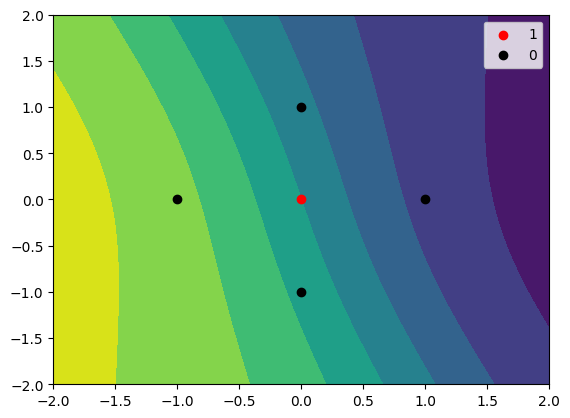

In [5]:

def plot_decision_boundary(x: Tensor, y: Tensor, net: NeuralNetwork) -> None:
    grid_range = torch.linspace(-2, 2, 50)
    grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='ij')
    grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T

    predictions = net.forward(grid_data)

    plt.contourf(grid_x, grid_y, predictions.view(grid_x.shape))
    plt.scatter(x[0, 0], x[0, 1], c='red', label='1')
    plt.scatter(x[1:, 0], x[1:, 1], c='black', label='0')
    plt.legend()
    plt.show()

plot_decision_boundary(x, y, network)

We can now finally train our network!

In [6]:

def train(
        x: Tensor,
        y: Tensor,
        net: NeuralNetwork,
        epochs: int,
        lr: float,
        verbose: int = 1,
) -> Tuple[NeuralNetwork, Tensor]:
    """
    Train a neural network.
    :param x: Training dataset.
    :param y: Training labels.
    :param net: Neural network to train.
    :param epochs: Number of training epochs.
    :param lr: Learning rate for gradient descent.
    :param verbose: Verbosity level. (number of epochs to print loss for)
    :return: Trained network and losses over course of training.
    """

    losses: List = []
    for ep in range(1, epochs + 1):
        loss = net.get_loss(x, y)
        losses.append(loss)
        net.backward(x, y)
        net.apply_gradients(learning_rate=lr)
        print('EPOCH: \t {:5} \t LOSS: \t {:.5f}'.format(ep, float(loss)), end='\r')

    return net, torch.stack(losses)

network, losses = train(x, y, network, 2500, 0.25, verbose=500)

By plotting the loss after each parameter update,
we can be sure that the network converged:

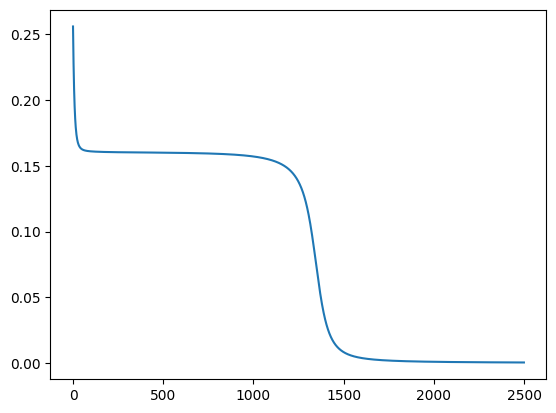

In [7]:

plt.plot(losses)
plt.show()

And the decision boundary of the network is:

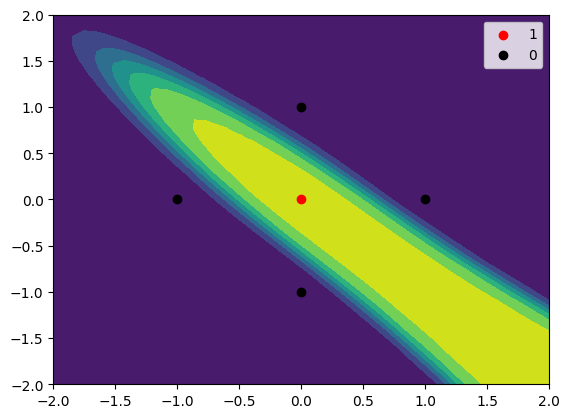

In [8]:

plot_decision_boundary(x, y, network)

Try to train a few randomly initialized networks and vary depth and hidden sizes
to discover different decision boundaries.
Try to modify the learning rate and see how it affects the convergence speed.
Finally, try different ways to initialize the weights and note how the
trainability of the network is affected.